Author: Rishab Sudhir

# Neighborhoods by Household Demographics

Okay so based on the bedrooms/res_units (doesn't matter too much which one we use) maps we can now map age demographic data onto it to see which demographics are being affected by the changes. First lets get the neighborhood data previous notebooks and load in the age demographic data.

In [49]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np


bedrooms_neighborhoods_df = pd.read_csv('../Demographic Data/bedrooms_neighborhoods_gdf.csv')

# Convert the 'geometry' column from WKT string back to geometry objects
bedrooms_neighborhoods_df['geometry'] = bedrooms_neighborhoods_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrames into GeoDataFrames
bedrooms_neighborhoods_df = gpd.GeoDataFrame(bedrooms_neighborhoods_df, geometry='geometry')


In [50]:
display(bedrooms_neighborhoods_df.head())

,OBJECTID,BlockGr202,Shape_Leng,Shape_Area,geometry,point_count,bedrooms_diff,color
0,1,Allston,35808.619278,4.154760e+07,"POLYGON ((-71.12123 42.36775, -71.12069 42.367...",30,16.0,green
1,2,Back Bay,18815.103609,1.538724e+07,"POLYGON ((-71.07315 42.35554, -71.07302 42.355...",49,-8.0,red
2,3,Beacon Hill,11668.951169,7.891524e+06,"POLYGON ((-71.06291 42.36123, -71.06286 42.360...",138,2.0,green
3,4,Brighton,47051.804654,7.658156e+07,"POLYGON ((-71.13737 42.35876, -71.13747 42.358...",127,63.0,green
4,5,Charlestown,33910.754786,5.127021e+07,"POLYGON ((-71.06700 42.39401, -71.06741 42.393...",221,22.0,green


In [51]:
# Set the CRS for the GeoDataFrames to the known CRS
bedrooms_neighborhoods_df.crs = 'EPSG:4326'

In [52]:
household_demographic_data = pd.read_csv('../Demographic Data/Household_Demographics.csv')

In [53]:
display(household_demographic_data.head())

,Neighborhood,Total,Married-couple family,Married-couple family Percent,"(Family)Male householder, no spouse present","(Family)Male householder, no spouse present Percent","(Family)Female householder, no spouse present","(Family)Female householder, no spouse present Percent",(Non-Family)Householder living alone,(Non-Family)Householder living alone Percent,(Non-Family)Householder not living alone,(Non-Family)Householder not living alone Percent
0,United States,"120,756,048","58,198,771",48.20%,"5,898,296",4.90%,"15,016,964",12.40%,"33,649,597",27.90%,"7,992,420",6.60%
1,Massachusetts,"2,617,497","1,231,768",47.10%,"111,970",4.30%,"315,562",12.10%,"745,793",28.50%,"212,404",8.10%
2,Boston,"269,522","76,336",28.30%,"11,921",4.40%,"41,285",15.30%,"97,609",36.20%,"42,371",15.70%
3,Allston,"6,526","1,102",16.90%,168,2.60%,327,5.00%,"2,431",37.30%,"2,498",38.30%
4,Back Bay,"9,829","2,675",27.20%,118,1.20%,423,4.30%,"5,143",52.30%,"1,470",15.00%


In [54]:
# Checking the data types of the columns
household_demographic_data.dtypes

Neighborhood                                             object
Total                                                    object
Married-couple family                                    object
Married-couple family Percent                            object
(Family)Male householder, no spouse present              object
(Family)Male householder, no spouse present Percent      object
(Family)Female householder, no spouse present            object
(Family)Female householder, no spouse present Percent    object
(Non-Family)Householder living alone                     object
(Non-Family)Householder living alone Percent             object
(Non-Family)Householder not living alone                 object
(Non-Family)Householder not living alone Percent         object
dtype: object

In [55]:
# Remove leading and trailing spaces from column names
household_demographic_data.columns = household_demographic_data.columns.str.strip()

In [56]:
# Checking the data types of the columns
household_demographic_data.dtypes

Neighborhood                                             object
Total                                                    object
Married-couple family                                    object
Married-couple family Percent                            object
(Family)Male householder, no spouse present              object
(Family)Male householder, no spouse present Percent      object
(Family)Female householder, no spouse present            object
(Family)Female householder, no spouse present Percent    object
(Non-Family)Householder living alone                     object
(Non-Family)Householder living alone Percent             object
(Non-Family)Householder not living alone                 object
(Non-Family)Householder not living alone Percent         object
dtype: object

In [57]:
percent_columns = ['Married-couple family Percent', '(Family)Male householder, no spouse present Percent', '(Family)Female householder, no spouse present Percent', '(Non-Family)Householder living alone Percent', '(Non-Family)Householder not living alone Percent']

for column in percent_columns:
    household_demographic_data[column] = pd.to_numeric(household_demographic_data[column].str.replace('%', '').str.strip(), errors='coerce')

# Confirm the changes
print(household_demographic_data.dtypes)


Neighborhood                                              object
Total                                                     object
Married-couple family                                     object
Married-couple family Percent                            float64
(Family)Male householder, no spouse present               object
(Family)Male householder, no spouse present Percent      float64
(Family)Female householder, no spouse present             object
(Family)Female householder, no spouse present Percent    float64
(Non-Family)Householder living alone                      object
(Non-Family)Householder living alone Percent             float64
(Non-Family)Householder not living alone                  object
(Non-Family)Householder not living alone Percent         float64
dtype: object


In [58]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Strip whitespace and convert to consistent case (e.g., uppercase) in the demographic DataFrame
household_demographic_data['Neighborhood'] = household_demographic_data['Neighborhood'].str.strip().str.upper()

# Do the same for the neighborhoods GeoDataFrame
bedrooms_neighborhoods_df['BlockGr202'] = bedrooms_neighborhoods_df['BlockGr202'].str.strip().str.upper()


# Find the modal age group by taking the idxmax of the percentage columns along the rows
age_columns = [col for col in household_demographic_data.columns if 'Percent' in col]
household_demographic_data['Modal_Household_Group'] = household_demographic_data[age_columns].idxmax(axis=1)

# Merge the modal age group data with the neighborhood GeoDataFrame
# Make sure the neighborhood names match between the two DataFrames and are in the same case
# Make sure the merge is being done in the right order and with the right column names
bedrooms_neighborhoods_df = bedrooms_neighborhoods_df.merge(household_demographic_data[['Neighborhood', 'Modal_Household_Group']], left_on='BlockGr202', right_on='Neighborhood', how='left')



In [59]:
display(bedrooms_neighborhoods_df)

,OBJECTID,BlockGr202,Shape_Leng,Shape_Area,geometry,point_count,bedrooms_diff,color,Neighborhood,Modal_Household_Group
0,1,ALLSTON,35808.619278,4.154760e+07,"POLYGON ((-71.12123 42.36775, -71.12069 42.367...",30,16.0,green,ALLSTON,(Non-Family)Householder not living alone Percent
1,2,BACK BAY,18815.103609,1.538724e+07,"POLYGON ((-71.07315 42.35554, -71.07302 42.355...",49,-8.0,red,BACK BAY,(Non-Family)Householder living alone Percent
2,3,BEACON HILL,11668.951169,7.891524e+06,"POLYGON ((-71.06291 42.36123, -71.06286 42.360...",138,2.0,green,BEACON HILL,(Non-Family)Householder living alone Percent
3,4,BRIGHTON,47051.804654,7.658156e+07,"POLYGON ((-71.13737 42.35876, -71.13747 42.358...",127,63.0,green,BRIGHTON,(Non-Family)Householder living alone Percent
4,5,CHARLESTOWN,33910.754786,5.127021e+07,"POLYGON ((-71.06700 42.39401, -71.06741 42.393...",221,22.0,green,CHARLESTOWN,(Non-Family)Householder living alone Percent
5,6,CHINATOWN,10843.828683,3.436019e+06,"POLYGON ((-71.05801 42.35235, -71.05817 42.352...",2,0.0,white,NaN,NaN
6,7,DORCHESTER,80692.139164,2.193038e+08,"POLYGON ((-71.05733 42.32804, -71.05720 42.328...",679,235.0,green,DORCHESTER,(Non-Family)Householder living alone Percent
7,8,DOWNTOWN,32767.370822,2.159010e+07,"MULTIPOLYGON (((-71.06456 42.35238, -71.06472 ...",1,NaN,white,DOWNTOWN,(Non-Family)Householder living alone Percent
8,9,EAST BOSTON,79266.383121,1.948618e+08,"POLYGON ((-71.00232 42.40094, -71.00188 42.400...",250,95.0,green,EAST BOSTON,Married-couple family Percent
9,10,FENWAY,101396.628071,4.281357e+07,"POLYGON ((-71.12701 42.37284, -71.12669 42.372...",10,-1.0,red,FENWAY,(Non-Family)Householder living alone Percent


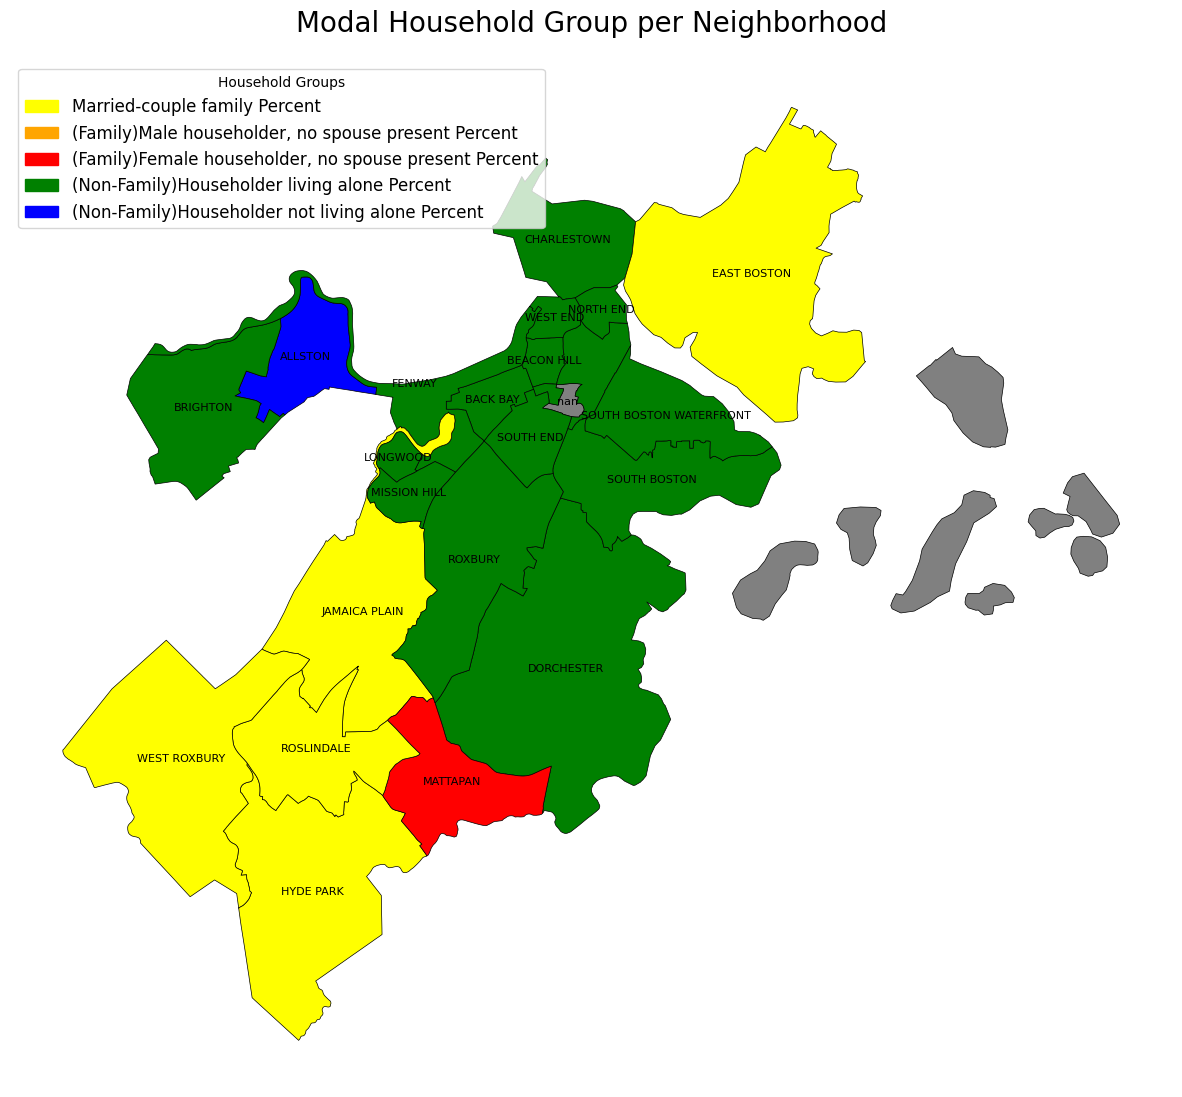

In [60]:


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Polygon

percent_columns = ['(Non-Family)Householder not living alone Percent']


# Create a color map for the modal age group
color_map = {
    'Married-couple family Percent': 'yellow',
    '(Family)Male householder, no spouse present Percent': 'orange',
    '(Family)Female householder, no spouse present Percent': 'red',
    '(Non-Family)Householder living alone Percent': 'green',
    '(Non-Family)Householder not living alone Percent': 'blue',
    'NaN': 'grey'  # Assign a default color for NaN values
}

# Map the modal age group to its corresponding color
bedrooms_neighborhoods_df['color'] = bedrooms_neighborhoods_df['Modal_Household_Group'].map(color_map)

# Replace NaN values in 'color' with the default color for NaN values
bedrooms_neighborhoods_df['color'].fillna(color_map['NaN'], inplace=True)

# Plot the map
fig, ax = plt.subplots(1, figsize=(15, 15))
bedrooms_neighborhoods_df.plot(ax=ax, color=bedrooms_neighborhoods_df['color'], edgecolor='black', linewidth=0.5)

# Create a patch (proxy artist) for each color map
patches = [mpatches.Patch(color=color, label=household_group) for household_group, color in color_map.items() if household_group != 'NaN']
plt.legend(handles=patches, title='Household Groups', loc='upper left', fontsize=12)

# Annotate the neighborhoods with their names
for idx, row in bedrooms_neighborhoods_df.iterrows():
    # Skip rows where the geometry is empty or invalid
    if isinstance(row['geometry'], Polygon):
        plt.annotate(text=row['Neighborhood'], 
                     xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', verticalalignment='center', fontsize=8)

# Remove axis off
ax.axis('off')

# Add title
plt.title('Modal Household Group per Neighborhood', fontsize=20, y=1.02)


# Show the map
plt.show()



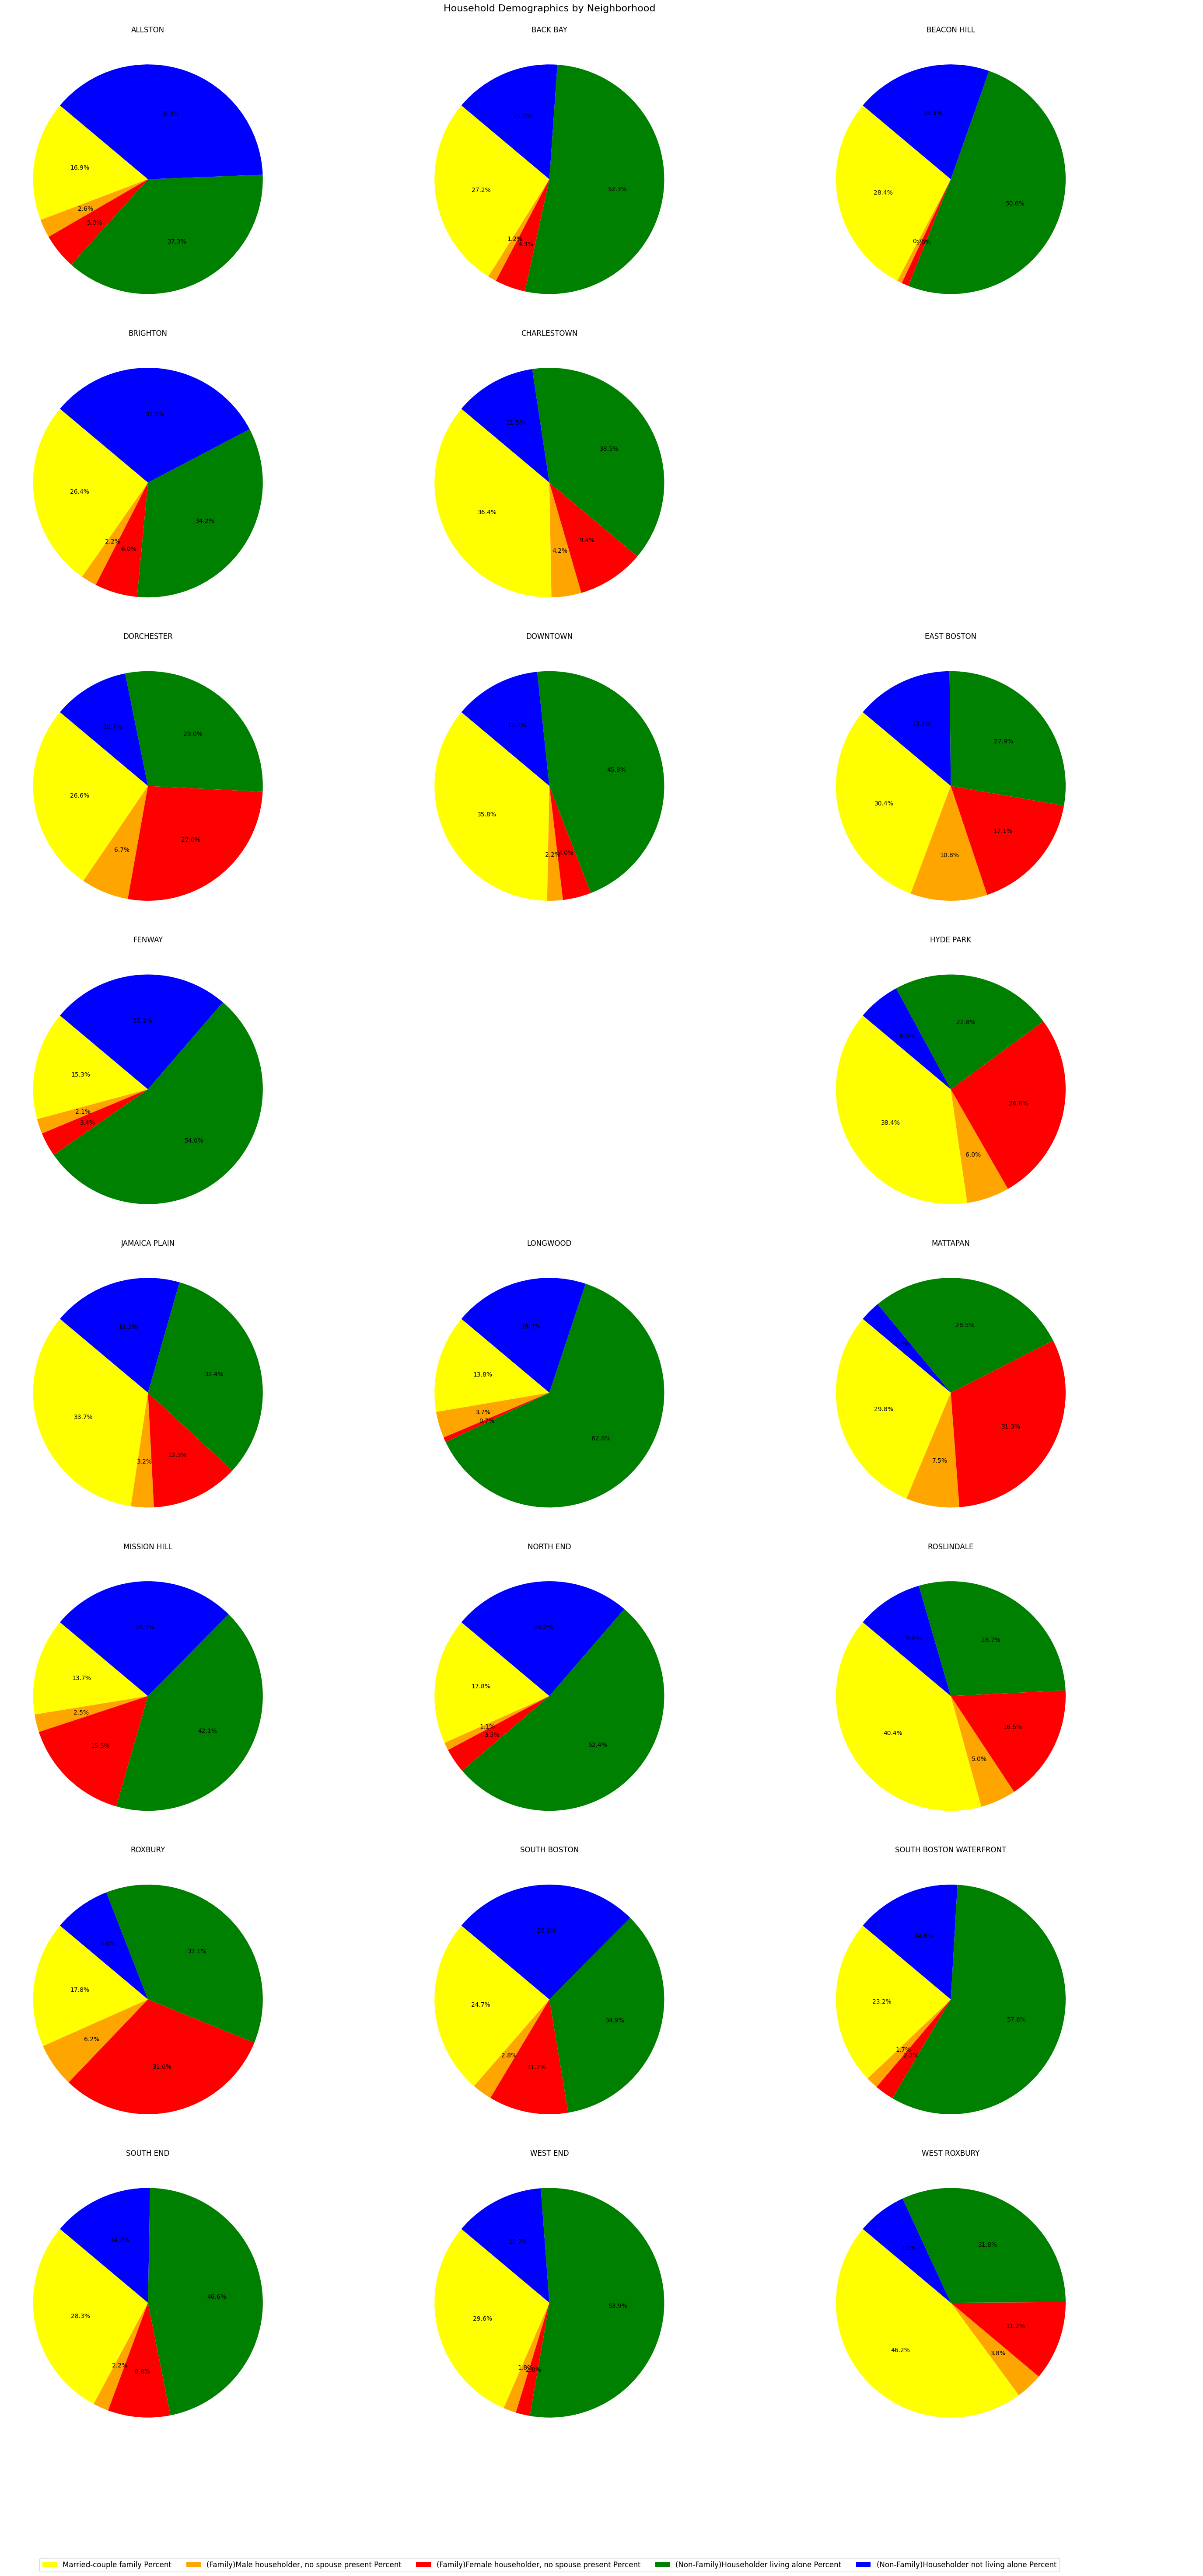

In [71]:
import matplotlib.pyplot as plt


# Define the categories and colors for the pie charts
household_categories = ['Married-couple family Percent', '(Family)Male householder, no spouse present Percent', '(Family)Female householder, no spouse present Percent', '(Non-Family)Householder living alone Percent', '(Non-Family)Householder not living alone Percent']

colors = ['yellow', 'orange', 'red', 'green', 'blue']

# Determine the layout of the subplots
nrows = int(np.ceil(len(bedrooms_neighborhoods_df) / 3.0))
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, nrows * 7))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Plot a pie chart for each neighborhood
for idx, (ax, neighborhood) in enumerate(zip(axes_flat, bedrooms_neighborhoods_df['Neighborhood'])):
    # Get the age distribution for the current neighborhood
    distribution = household_demographic_data[household_demographic_data['Neighborhood'] == neighborhood][household_categories].values.flatten().tolist()
    
    # If the neighborhood has no data, continue to the next iteration
    if not distribution:
        ax.axis('off')  # Hide the axis if no data
        continue
    
    # Create the pie chart without labels
    wedges, texts, autotexts = ax.pie(distribution, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(neighborhood)

# Hide any unused axes
for ax in axes_flat[idx+1:]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Add an overall title
plt.suptitle('Household Demographics by Neighborhood', fontsize=16, y=1)


# Add a legend at the bottom of the figure using the wedges from the last pie chart
# Ensure the legend is visible and not overlapped by modifying 'bbox_to_anchor'
fig.legend(wedges, household_categories, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(household_categories), fontsize='large')



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
